In [3]:
import os
import re
import zipfile

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from PIL import Image
from PIL import ImageFilter
import ast
import json
from glob import glob

In [4]:
path_annotation = '/home/mvlab/Notebook/pedestrian/predict (copy).csv'
#path_annotation = '/home/mvlab/Notebook/pedestrian/predict.csv'
os.path.isfile(path_annotation)

True

In [5]:
df = pd.read_csv(path_annotation)
df.shape

(79762, 8)

In [6]:
df = df.drop(columns='Unnamed: 0')

In [7]:
df.path.values

array(['/media/mvlab/46FA9CA2FA9C8FB3/dataset/pedestrian/Tongyoung/event/미수_스마트시티_통영대교_미수방향1(Ch 01)_[20201217]163000-[20201218]090000(20201217_163000)_손올리기/06479.jpg',
       '/media/mvlab/46FA9CA2FA9C8FB3/dataset/pedestrian/Tongyoung/event/미수_스마트시티_통영대교_미수방향1(Ch 01)_[20201217]163000-[20201218]090000(20201217_163000)_손올리기/12959.jpg',
       '/media/mvlab/46FA9CA2FA9C8FB3/dataset/pedestrian/Tongyoung/event/미수_스마트시티_통영대교_미수방향1(Ch 01)_[20201217]163000-[20201218]090000(20201217_163000)_손올리기/12959.jpg',
       ...,
       '/media/mvlab/46FA9CA2FA9C8FB3/dataset/pedestrian/Tongyoung/event/미수_스마트시티_통영대교_미수방향2(Ch 01)_[20201217]163000-[20201218]090000(20201217_163000)_손올리기/07747.jpg',
       '/media/mvlab/46FA9CA2FA9C8FB3/dataset/pedestrian/Tongyoung/event/미수_스마트시티_통영대교_미수방향2(Ch 01)_[20201217]163000-[20201218]090000(20201217_163000)_손올리기/07747.jpg',
       '/media/mvlab/46FA9CA2FA9C8FB3/dataset/pedestrian/Tongyoung/event/미수_스마트시티_통영대교_미수방향2(Ch 01)_[20201217]163000-[20201218]090000(20201217_16300

In [8]:
for i in range(len(df)):
    path = df.iloc[i]['path']
    
    video_name = path.split(os.sep)[-2]
    frame = path.split(os.sep)[-1][:-4]
    frame = int(frame)
    #print(i, video_name, frame)
    
    df.loc[i, 'fr'] = frame
    df.loc[i, 'video'] = video_name
    if i%10000:
        print(i)
    #break

In [9]:
df.video.nunique(), df.video.unique()

(2,
 array(['미수_스마트시티_통영대교_미수방향1(Ch 01)_[20201217]163000-[20201218]090000(20201217_163000)_손올리기',
        '미수_스마트시티_통영대교_미수방향2(Ch 01)_[20201217]163000-[20201218]090000(20201217_163000)_손올리기'],
       dtype=object))

In [11]:
def visualize_detections_simple(
    image, boxes, classes, figsize=(12, 12), linewidth=1, color=[0, 0, 1]
):
    """Visualize Detections"""
    image = np.array(image, dtype=np.uint8)    
    
    img_h, img_w, img_c = image.shape
    
    #image = attach_crop_image(image, boxes, max_crop=100)
    
    plt.figure(figsize=figsize)
    plt.axis("off")
    plt.imshow(image)
    ax = plt.gca()
    boxes_width = boxes[:, 2] - boxes[:, 0]
    boxes_height = boxes[:, 3] - boxes[:, 1]
    box_min_width = np.min(boxes_width)
    box_max_width = np.max(boxes_width)
    title = str.format('(%dx%d) %d box, width:%d ~ %d' 
                       %(img_h, img_w, len(boxes), box_min_width, box_max_width))
    plt.title(title)
    for box, cls in zip(boxes, classes):
        x1, y1, x2, y2 = box        
        w, h = x2 - x1, y2 - y1
        
        color = [1, 1, 1]
        patch = plt.Rectangle(
            [x1, y1], w, h, fill=False, edgecolor=color, linewidth=linewidth
        )
        ax.add_patch(patch)
        if len(boxes) < 70:
            #score_txt = class_names[int(cls)]
            score_txt = str(int(cls))
            ax.text(x1, y1, score_txt, bbox={"facecolor": [1,1,0], "alpha": 0.4}, clip_box=ax.clipbox, clip_on=True,)
        
    plt.show()
    return ax


In [12]:
i = 2
sample_path = df.loc[i, 'path']
img = Image.open(sample_path)
img.size

(1920, 1080)

In [16]:
df_target = df[df.path==sample_path]

cboxes = df_target[['cls','x0', 'y0', 'x1', 'y1']].values
cls = cboxes[:, 0] 
boxes = cboxes[:, 1:]/0.9481481481481482
cboxes

array([[  3, 872, 506, 892, 559],
       [  3, 879, 445, 892, 470],
       [  1, 896, 444, 907, 468]])

In [17]:
image = np.array(img)
min_side = 1024
image_shape = image.shape[:2]
ratio = min_side / np.min(image_shape)
ratio

0.9481481481481482

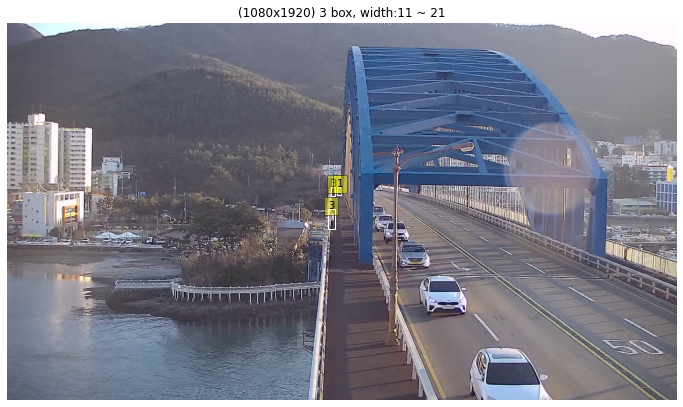

<AxesSubplot:title={'center':'(1080x1920) 3 box, width:11 ~ 21'}>

In [18]:
visualize_detections_simple(img, boxes, cls)

In [ ]:
(1024, 1920)

- Dark Label format
- fr, class, id, x0, y0, w, h
- 5,lie/sleep,2,576,143,308,184

In [ ]:
def convert_annotation_to_dark_label_format(df):
    df_darklabel = df[['fr', 'cls', 'x0', 'y0']].copy()
    df_darklabel['id'] = 0
    df_darklabel['h'] = df.y1 - df.y0
    df_darklabel['w'] = df.x1 - df.x0
    df_darklabel = df_darklabel.astype(int).sort_values('fr')
    
    return df_darklabel

df_darklabel = convert_annotation_to_dark_label_format(df)
df_darklabel

In [ ]:
df_darklabel.fr.nunique()

In [ ]:
df_darklabel.to_csv('df_darklabel.csv')